In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors as colors
from scipy.io import loadmat
from dask.distributed import Client
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from gsw import f, Nsquared, p_from_z, z_from_p

In [2]:
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39353,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39053,Total threads: 4
Dashboard: /proxy/44887/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:34867,


In [3]:
fiM2 = loadmat("/g/data/nm03/lxy581/matlab_model/synbath025_depth_var_kbar_Nbar.mat")
# print(list(fiM2.keys()))   

depth_var_M2 = fiM2['depth_var'][:]
mean_depth_M2 = fiM2['mean_depth'][:]
lat_out = np.squeeze(fiM2['lat_out'][:])
lon_out = np.squeeze(fiM2['lon_out'][:])
N = np.squeeze(fiM2['Narray'][:])
kbar = np.squeeze(fiM2['Kbar'][:])
LONi, LATi = np.meshgrid(lon_out,lat_out,indexing='ij')
omega_M2=1.405189e-4
omega_earth=2*np.pi/(24*60**2)
fout=2*omega_earth*np.sin(np.pi/180*LATi)
sigma_real_M2 = N*np.sqrt(omega_M2**2-fout**2)/2/np.abs(omega_M2)*kbar*depth_var_M2
# turn off for f>omega
sigma_real_M2[omega_M2<np.abs(fout)]=np.nan

/jobfs/156278765.gadi-pbs/ipykernel_19546/3125746181.py:14: RuntimeWarning: invalid value encountered in sqrt
  sigma_real_M2 = N*np.sqrt(omega_M2**2-fout**2)/2/np.abs(omega_M2)*kbar*depth_var_M2


In [4]:
LONr, LATr = np.meshgrid(lon_out,lat_out,indexing='xy')
sigma_real_M2 = np.transpose(sigma_real_M2)

In [5]:
print(sigma_real_M2.shape)
print(LONr.shape)

(719, 1440)
(719, 1440)


In [6]:
SAH_8km = '/g/data/nm03/lxy581/input/tides_008deg_drag_coeff/sigma_SAH_M2_008_1deg_2d_global.nc'
data_SAH_8km = xr.open_dataset(SAH_8km)
lon_8km = data_SAH_8km.geolon
lat_8km = data_SAH_8km.geolat
sigma_SAH_8km = data_SAH_8km.sigma_mag

In [7]:
print(sigma_SAH_8km.shape)
print(lon_8km.shape)

(3270, 4320)
(3270, 4320)


### plot to make sure units are the same

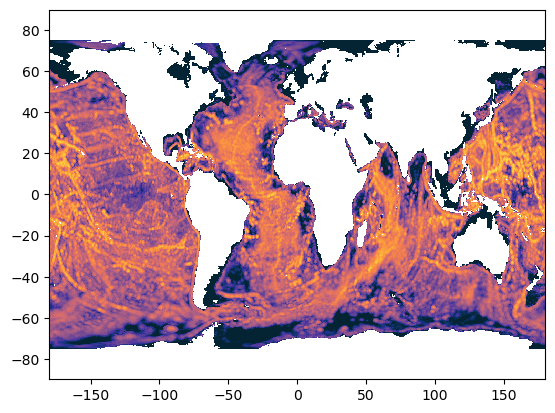

In [8]:
plt.pcolormesh(LONr,LATr,sigma_real_M2,cmap = cm.cm.thermal, norm=LogNorm(vmin=1e-5, vmax=1e-1))

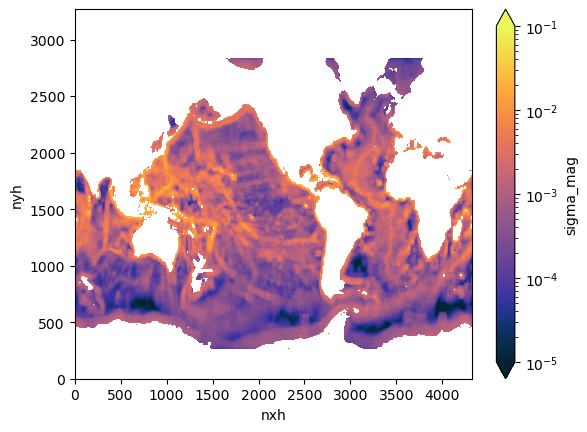

In [9]:
sigma_SAH_8km.plot(cmap=cm.cm.thermal,norm=LogNorm(vmin=1e-5, vmax=1e-1),extend="both")

### interpolate Callum's SAH drag coefficients (topography variance calculated in 1D) to 8km grid (on the staggered grid)

Also mask the shallow regions

In [10]:
fgrid = '/g/data/nm03/lxy581/archive/tides_008_global_sigma_x06/output002/ocean_static.nc' # 1/12-deg
hgrid = xr.open_dataset(fgrid)
mom_xh = np.array(hgrid.xh)
mom_yh = np.array(hgrid.yh)
mom_xq = np.array(hgrid.xq)
mom_yq = np.array(hgrid.yq)
deptho = np.array(hgrid.deptho)
mom_nyh, mom_nxh = mom_yh.size, mom_xh.size
mom_nyq, mom_nxq = mom_yq.size, mom_xq.size

In [11]:
geolon = np.array(hgrid['geolon'])
geolat = np.array(hgrid['geolat'])
geolon_u = np.array(hgrid['geolon_u'])
geolat_u = np.array(hgrid['geolat_u'])
geolon_v = np.array(hgrid['geolon_v'])
geolat_v = np.array(hgrid['geolat_v'])

In [12]:
ds_low = xr.Dataset(data_vars={'sigma_xx_008': (('yh','xh'), np.array(sigma_real_M2)),
                               'sigma_yy_008': (('yh','xh'), np.array(sigma_real_M2)),
                               }, 
                    coords={'lon': (('yh','xh'), np.array(LONr)),
                            'lat': (('yh','xh'), np.array(LATr))})

ds_high_u = xr.Dataset(data_vars={"lat": (('ny','nx'), geolat_u),
                                  "lon": (('ny','nx'), geolon_u),
                                 },
                       coords={"ny":np.arange(mom_nyh), "nx":np.arange(mom_nxq)})
ds_high_v = xr.Dataset(data_vars={"lat": (('ny','nx'), geolat_v),
                                  "lon": (('ny','nx'), geolon_v),
                                 },
                       coords={"ny":np.arange(mom_nyq), "nx":np.arange(mom_nxh)})

regridder2_u = xe.Regridder(ds_low, ds_high_u, "bilinear", extrap_method="inverse_dist")#, reuse_weights=True, weights=
                           #"/g/data/nm03/lxy581/global_drag_coeff/JSL25km_h_to_8km_u_weights.nc")
regridder2_v = xe.Regridder(ds_low, ds_high_v, "bilinear", extrap_method="inverse_dist")#, reuse_weights=True, weights=
                           #"/g/data/nm03/lxy581/global_drag_coeff/JSL25km_h_to_8km_v_weights.nc")

ds_high_u = regridder2_u(ds_low)
ds_high_v = regridder2_v(ds_low)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect

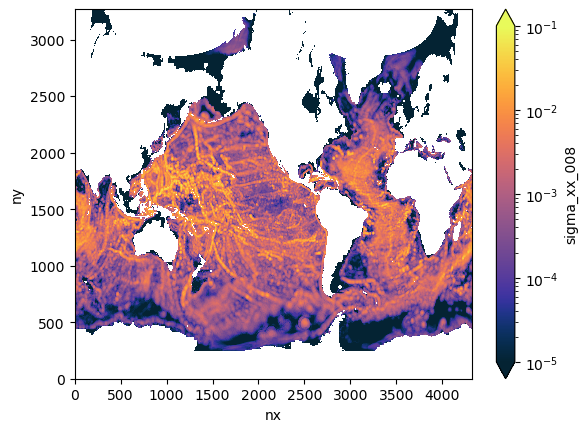

In [13]:
ds_high_u.sigma_xx_008.plot(cmap=cm.cm.thermal,norm=LogNorm(vmin=1e-5, vmax=1e-1),extend="both")

### Interpolate 8km-h-grid depth to u-grid and v-grid 

In [14]:
ds_high_dep_h = xr.Dataset(data_vars={
                                   'depth_008': (('yh','xh'), deptho),
                                   }, 
                        coords={"lat": (('yh','xh'), geolat),
                                "lon": (('yh','xh'), geolon)})

ds_high_dep_u = xr.Dataset(data_vars={"lat": (["ny"], mom_yh),
                                      "lon": (["nx"], mom_xq),
                                     },
                           coords={"ny":np.arange(mom_nyh), "nx":np.arange(mom_nxq)})
ds_high_dep_v = xr.Dataset(data_vars={"lat": (["ny"], mom_yq),
                                      "lon": (["nx"], mom_xh),
                                     },
                           coords={"ny":np.arange(mom_nyq), "nx":np.arange(mom_nxh)})

regridder3_u = xe.Regridder(ds_high_dep_h, ds_high_dep_u, "bilinear", extrap_method="inverse_dist", reuse_weights=True, weights=
                           "/g/data/nm03/lxy581/global_drag_coeff/8km_h_to_8km_u_weights.nc")
regridder3_v = xe.Regridder(ds_high_dep_h, ds_high_dep_v, "bilinear", extrap_method="inverse_dist", reuse_weights=True, weights=
                           "/g/data/nm03/lxy581/global_drag_coeff/8km_h_to_8km_v_weights.nc")

ds_high_dep_u = regridder3_u(ds_high_dep_h)
ds_high_dep_v = regridder3_v(ds_high_dep_h)


In [15]:
np.nanmin(ds_high_dep_u.depth_008)

9.5

In [16]:
dep_global_u = np.array(ds_high_dep_u['depth_008'])
dep_global_v = np.array(ds_high_dep_v['depth_008'])

def make_nan_poleward_critical_lat(var,dep_var,mom_lat,mom_lon):
    var_global = np.zeros(np.array(var).shape)
    var_global = np.array(var)
    var_global[np.isnan(dep_var)==1]=0.0
    var_global[mom_lat>74.48]=0.0
    var_global[mom_lat<-74.48]=0.0
    return var_global

fac_dep_v = xr.where(ds_high_dep_v["depth_008"] > 1000, 1, 0) 
fac_dep_u = xr.where(ds_high_dep_u["depth_008"] > 1000, 1, 0)

JSL_xx_global  = make_nan_poleward_critical_lat(ds_high_u['sigma_xx_008'],dep_global_u,mom_yh,mom_xq) * np.array(fac_dep_u) 
JSL_yy_global  = make_nan_poleward_critical_lat(ds_high_v['sigma_yy_008'],dep_global_v,mom_yq,mom_xh) * np.array(fac_dep_v)

JSL_data = xr.Dataset(data_vars={
                                 "sigma_xx": (["nyh","nxq"], JSL_xx_global),
                                 "sigma_yy": (["nyq","nxh"], JSL_yy_global),
                                 
                                 "geolon": (["nyh","nxh"], geolon),
                                 "geolat": (["nyh","nxh"], geolat),
                                 "geolon_u": (["nyh","nxq"], geolon_u),
                                 "geolat_u": (["nyh","nxq"], geolat_u),
                                 "geolon_v": (["nyq","nxh"], geolon_v),
                                 "geolat_v": (["nyq","nxh"], geolat_v),
                                 
                                 "depth_u": (["nyh","nxq"], dep_global_u),
                                 "depth_v": (["nyq","nxh"], dep_global_v),
                                },
                      coords={"yh": (["nyh"], np.array(hgrid.yh)),
                            "yq": (["nyq"], np.array(hgrid.yq)),
                            "xq": (["nxq"], np.array(hgrid.xq)),
                            "xh": (["nxh"], np.array(hgrid.xh))},
                      attrs={'long_name': 'JSL drag coefficient (M2)', 'units': 'm second-1'})

# JSL_data.to_netcdf('/g/data/nm03/lxy581/global_drag_coeff/sigma_JSL_M2_008_2d_global.nc')
JSL_data.to_netcdf('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_1Dtopog_M2_008_2d_global.nc')


In [17]:
sigma_xx_mask = ds_high_u['sigma_xx_008'] * fac_dep_u

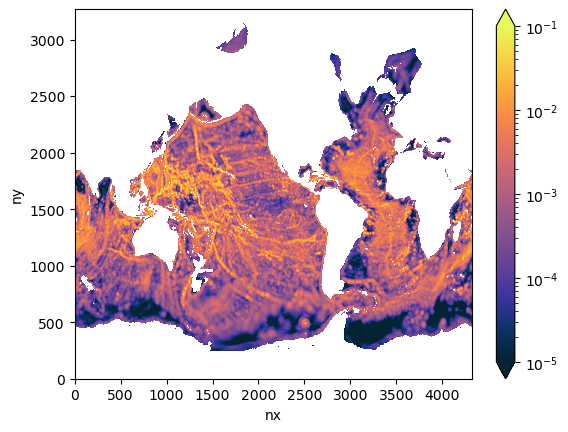

In [18]:
sigma_xx_mask.plot(cmap=cm.cm.thermal,norm=LogNorm(vmin=1e-5, vmax=1e-1),extend="both")

In [19]:
sigma_yy_mask = ds_high_u['sigma_yy_008'] * fac_dep_v

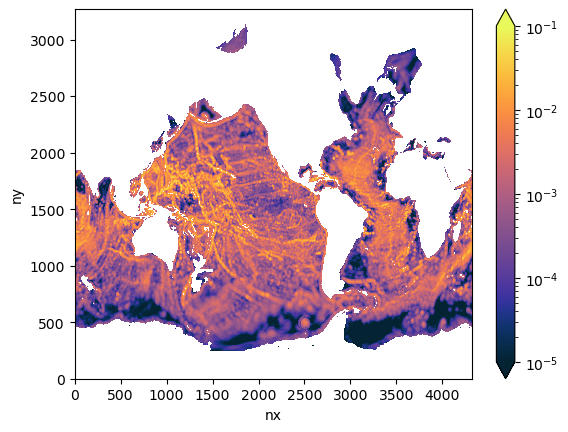

In [20]:
sigma_yy_mask.plot(cmap=cm.cm.thermal,norm=LogNorm(vmin=1e-5, vmax=1e-1),extend="both")